recording along 748 channels
brain areas recorded in that animal
['MOs' 'MRN' 'OLF' 'ORB' 'PAG' 'RSP' 'SCm' 'SCs' 'root']
Channels of Neuropixel probe in frontal_cortices
200
number of clusters in cluster_idx = 
778
number of "good" and "unsorted" clusters in cluster_idx = 
522
Number of clean clusters in frontal_cortices
92
number of clusters in spikeclusters = 
778
recording along 748 channels
brain areas recorded in that animal
['MOs' 'MRN' 'OLF' 'ORB' 'PAG' 'RSP' 'SCm' 'SCs' 'root']
Channels of Neuropixel probe in midbrain
280
number of clusters in cluster_idx = 
778
number of "good" and "unsorted" clusters in cluster_idx = 
522
Number of clean clusters in midbrain
98
number of clusters in spikeclusters = 
778


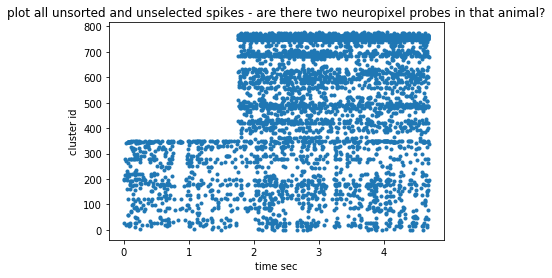

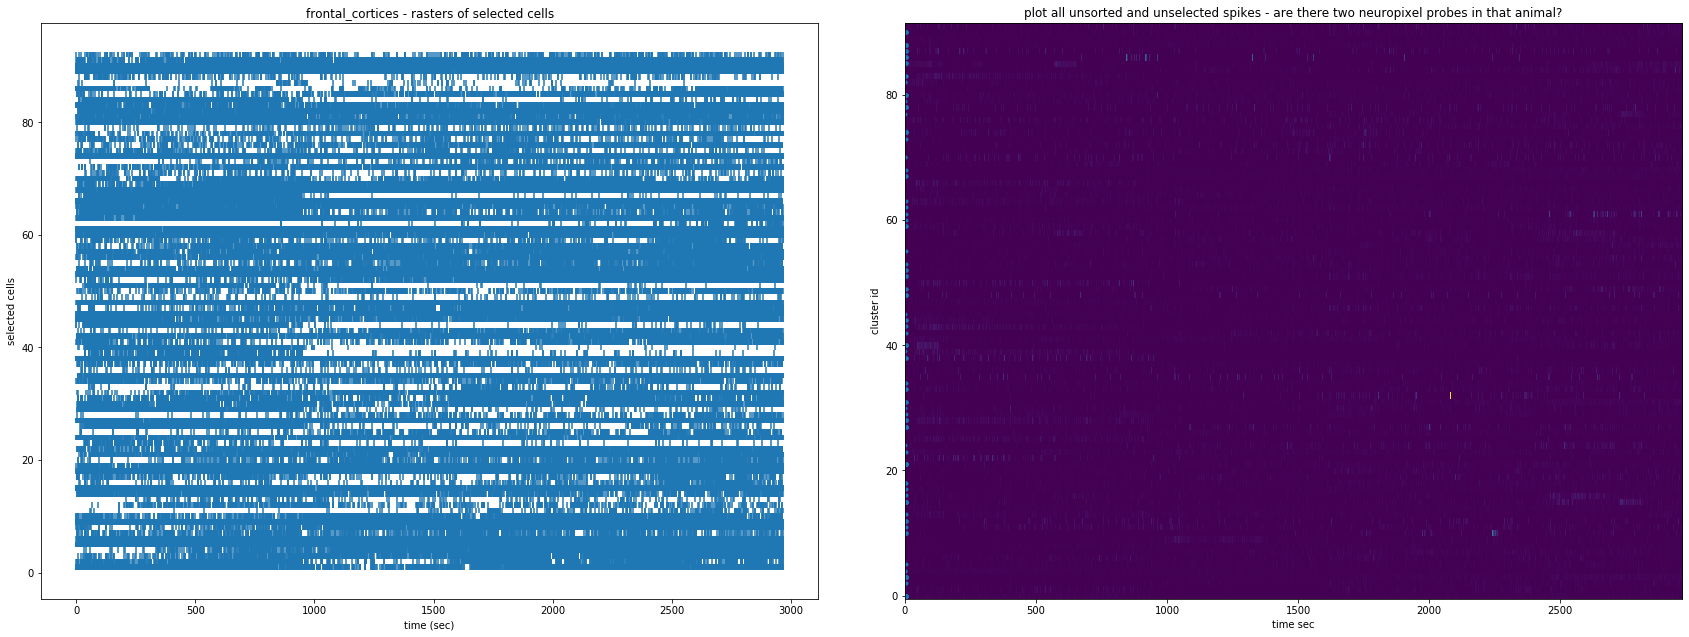

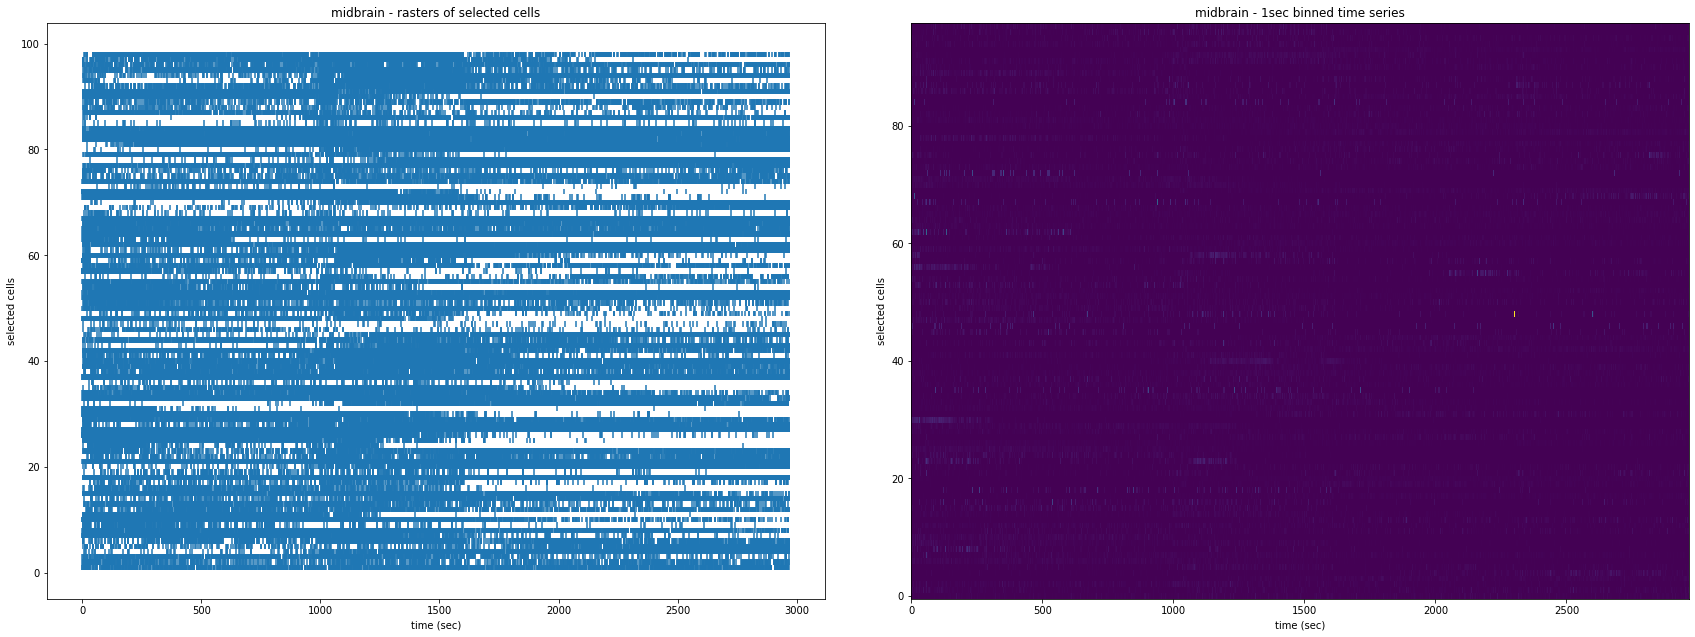

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_population_timeseries_matrices(listsofareas, labels, binning_resolution_sec=1):
    
    # inputs --> lists of area ; N list of areas as many as you want (see example below)
    # returns All_binned_timeseries as N arrays in one array (I think)
    
    ## how to use it 
    ## define cluster of brain areas
    # mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
    # frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

    # population_matrices = get_population_timeseries_matrices([mid_brain_circuits, frontal_circuits], binningresol_sec = 1)
    
    
    
    ## defining data path --> to improve --> write as optional input
    all_data_path='/Users/jean/git/steinmetz-et-al-2019/data'
    selected_recordings= 'Richards_2017-10-31'
    
    
    
    
    ## returns as many population matrices as len(listsofareas)
    ## each population matrix is a N cells X ~ duration/binningresol_sec array
    All_binned_timeseries = [];
    for brainareaidx in np.arange(len(listsofareas)):
        BrainArea = listsofareas[brainareaidx]
        ##
        individualchannel_location = pd.read_csv(all_data_path +'/'+selected_recordings+'/'+'channels.brainLocation.tsv', sep='\t')
        # allen_ontology [enumerated string] (nChannels) The acronym of the brain region determined to contain this channel in the Allen CCF.
        individualchannel_location = individualchannel_location.allen_ontology;
        individualchannel_location = np.array(individualchannel_location)
        print('recording along '+ str(len(individualchannel_location)) +' channels')
        print('brain areas recorded in that animal')
        #print(individualchannel_location)
        print(np.unique(individualchannel_location))
        #from pandas library --> pd.Series
        #pandas_location = pd.Series(individualchannel_location)
        # pd.SeriesObject.str.match --> to find a string
        # USE 2 for loops to get the index of the channels in the right areas
        Channels_in_region_of_interest = []
        All_selected_regions = []
        for ThatRegOIfInt in BrainArea:
            for chan in np.arange(len(individualchannel_location)):
                if individualchannel_location[chan] == ThatRegOIfInt:
                    Channels_in_region_of_interest.append(chan)
                    All_selected_regions.append(individualchannel_location[chan])

        # convert list to np.array
        Channels_in_region_of_interest = np.array(Channels_in_region_of_interest)
        All_selected_regions = np.array(All_selected_regions);
        print('Channels of Neuropixel probe in ' +labels[brainareaidx])
        # find indices of the firt unique values in Channels_in_region_of_interest
        _, unique_idx = np.unique(Channels_in_region_of_interest, return_index=True)
        # select unique channel idx and corresponding areas
        Channels_in_region_of_interest =Channels_in_region_of_interest[unique_idx]
        All_selected_regions = All_selected_regions[unique_idx]
        #print(All_selected_regions)
        print(len(Channels_in_region_of_interest))
        
        ## cluster indices from "good spikes" from the 'clusters' objects 
        cluster_quality = np.load(all_data_path +'/'+selected_recordings+'/'+'clusters._phy_annotation.npy')
        print('number of clusters in cluster_idx = ')
        print(len(cluster_quality))
        # 0 = noise (these are already excluded and don't appear in this dataset at all); 
        # 1 = MUA (i.e. presumed to contain spikes from multiple neurons; 
        # these are not analyzed in any analyses in the paper); 
        # 2 = Good (manually labeled); 3 = Unsorted. 
        # In this dataset 'Good' was applied in a few but not all datasets to included neurons, 
        # so in general the neurons with _phy_annotation>=2 are the ones that should be included.
        clusters_idx = np.arange(len(cluster_quality))
        cluster_good_where = np.where(cluster_quality>=2);
        cluster_good_where = cluster_good_where[0]
        good_and_unsorted_clusters = clusters_idx[cluster_good_where]
        print('number of "good" and "unsorted" clusters in cluster_idx = ')
        print(len(good_and_unsorted_clusters))

        # location of the cluster peak along the neuropixel probe
        cluster_peakChannel =  np.load(all_data_path +'/'+selected_recordings+'/'+'clusters.peakChannel.npy')
        
        #intersection of cluster_peakChannel and Channels_in_region_of_interest
        #print(cluster_peakChannel
        #print(Channels_in_region_of_interest)
        ClusterInRightArea = np.intersect1d(cluster_peakChannel, Channels_in_region_of_interest,
                                    assume_unique = False, return_indices = False)
        
        ## clusters from clean clusters and right area
        clean_Clusters_InTheRightArea = np.intersect1d(ClusterInRightArea, good_and_unsorted_clusters, 
                                                       assume_unique = False, return_indices=False)
        print('Number of clean clusters in '+labels[brainareaidx])
        print(len(clean_Clusters_InTheRightArea))
        #print(clean_Clusters_InTheRightArea)

        
        ## spikes and cluster idx from the 'spikes' object
        spiketimes = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.times.npy')
        spikeclusters = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.clusters.npy')
        ## to check if it corresponds to clusters class
        ## the numbers in there match raws of the cluster objects (see below)
        uniquespikeclusters = np.unique(spikeclusters)
        print('number of clusters in spikeclusters = ')
        print(len(uniquespikeclusters))

        # ploting the 5000 nth spikes, picked from all the clusters
        firstspiketoplot = 0
        numberofspikestoplot = 5000
        idtoplot = np.arange(firstspiketoplot, firstspiketoplot+numberofspikestoplot)
        plt.plot(spiketimes[idtoplot], spikeclusters[idtoplot], '.')
        plt.xlabel('time sec')
        plt.ylabel('cluster id')
        plt.title('plot all unsorted and unselected spikes - are there two neuropixel probes in that animal?')
        
        ## for histogram
        #binning_resolution_sec = 20 #sec 
        numberofbins = int(round(np.max(spiketimes)/binning_resolution_sec)); #
        #print(numberofbins)
        bins = np.linspace(0, int(np.max(spiketimes)+1), numberofbins)
        #print(np.max(spiketimes))
        #bins.shape
        FigRaster = plt.figure() # initializing figure rasters
        FigRasterAx = FigRaster.add_axes([0.1, 0.1, 1.8, 2])
        ## preallocating
        binned_timeseries = np.zeros((len(clean_Clusters_InTheRightArea), len(bins)-1))

        ## iteratively selecting spikes from distinct cluster and generating an array of N arrays for N cells
        for thatspike in np.arange(len(clean_Clusters_InTheRightArea)):
            #print(clean_Clusters_InTheRightArea[thatspike])
            #length(clean_Clusters_InTheRightArea[thatspike])
            those_spike_indices = (spikeclusters == clean_Clusters_InTheRightArea[thatspike])
            #print(spiketimes[those_spike_indices])
            FigRasterAx.eventplot(spiketimes[those_spike_indices], lineoffsets=thatspike+1)

            # building histogram --> 20 ms binning of the data
            # starting at time = 0 to max(spiketimes)
            binned_timeseries[thatspike,:], bin_edges = np.histogram(spiketimes[those_spike_indices], bins, density=True) 


        bin_center = bin_edges[:-1] + (np.min(np.diff(bin_edges))/2)


        FigRasterAx.set_ylabel('selected cells')
        FigRasterAx.set_xlabel('time (sec)')
        FigRasterAx.set_title(labels[brainareaidx]+' - rasters of selected cells')
        FigRasterAx.axis('tight')

        ## visualising time series color plot
        #FigTimeSeries = plt.figure() # initializing figure TimeSeries
        FigTimeSeriesAx = FigRaster.add_axes([2.1, .1, 1.8, 2])
        FigTimeSeriesAx.imshow(binned_timeseries)
        FigTimeSeriesAx.axis('tight')
        FigTimeSeriesAx.set_ylabel('selected cells')
        FigTimeSeriesAx.set_xlabel('time (sec)')
        FigTimeSeriesAx.set_title(labels[brainareaidx]+' - '+str(binning_resolution_sec)+'sec binned time series')
        FigTimeSeriesAx.invert_yaxis()
        
        All_binned_timeseries.append([binned_timeseries])
        
         
    return All_binned_timeseries
    
    
#### Example on how use it 
## define cluster of brain areas
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
        
population_matrices = get_population_timeseries_matrices([frontal_circuits, mid_brain_circuits], 
                                                         labels=['frontal_cortices', 'midbrain'], 
                                                         binning_resolution_sec = 10)
FrontalMatrix = population_matrices[0][0]
MidBrainMatrix = population_matrices[1][0]


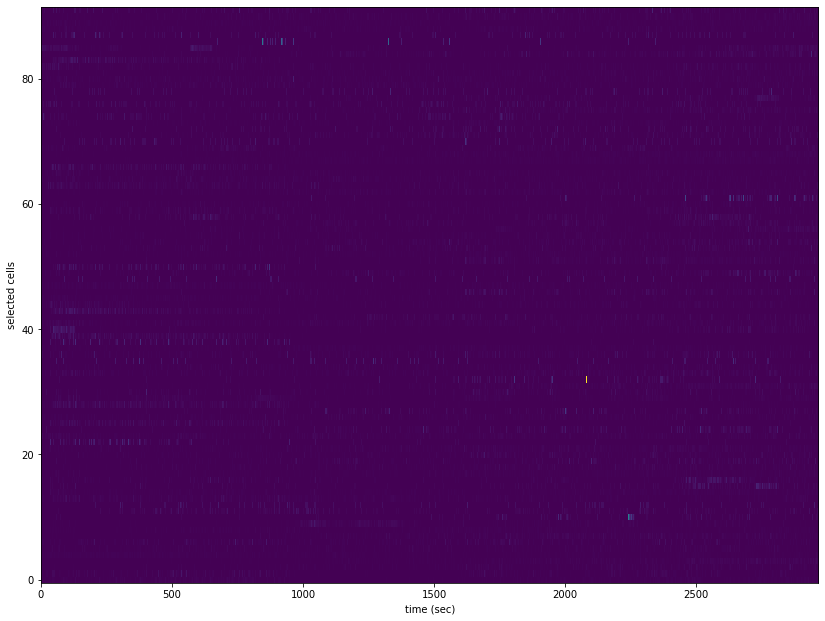

In [23]:
## print(population_matrices[1][0])
FigTimeSeries = plt.figure() # initializing figure TimeSeries
FigTimeSeriesAx = FigTimeSeries.add_axes([2.1, .1, 1.8, 2])
FigTimeSeriesAx.imshow(population_matrices[1][0])
FigTimeSeriesAx.axis('tight')
FigTimeSeriesAx.set_ylabel('selected cells')
FigTimeSeriesAx.set_xlabel('time (sec)')
FigTimeSeriesAx.invert_yaxis()

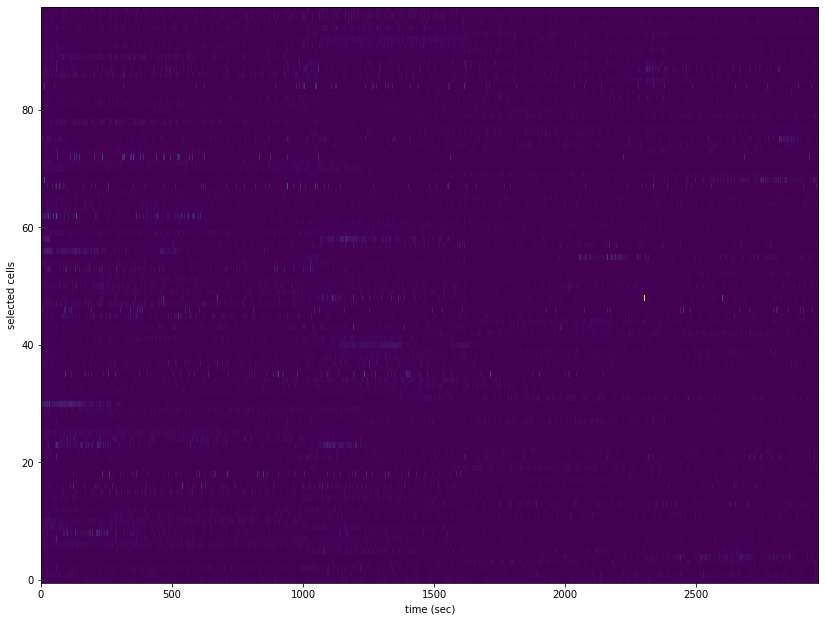

In [24]:
## print(population_matrices[0][0])
FigTimeSeries = plt.figure() # initializing figure TimeSeries
FigTimeSeriesAx = FigTimeSeries.add_axes([2.1, .1, 1.8, 2])
FigTimeSeriesAx.imshow(population_matrices[0][0])
FigTimeSeriesAx.axis('tight')
FigTimeSeriesAx.set_ylabel('selected cells')
FigTimeSeriesAx.set_xlabel('time (sec)')
FigTimeSeriesAx.invert_yaxis()
